In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks


/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

import experiment_utils
import util

import imageio


import jax
import jax.numpy as jnp
from jax.random import split
from clip_jax import MyFlaxCLIP
import imageio
from umap import UMAP

# clip_model = MyFlaxCLIP()

In [3]:
from create_sim import create_sim, rollout_and_embed_simulation, rollout_simulation, FlattenSimulationParameters
from models.models_gol import GameOfLife

In [11]:
img_size = 128
cover_video = []

In [12]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_lenia_1.0_large/", "pop")
sim = FlattenSimulationParameters(create_sim('lenia_1.0'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=256, img_size=img_size, n_rollout_imgs='video'))

# params = pop['params'][np.array([5729, 5069, 5331, 4443, 4687, 5685, 5566, 5562, 5820, 4893, 4894, 1170, 1163, 1933, 1153, 29])]
params = pop['params'][np.array([5729, 5069, 5331, 4443, 4687, 5685, 5566, 5562, 1300, 4893, 4894, 1170, 1163, 1933, 1153, 29])]
rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
vid = jax.image.resize(vid, (len(vid), 1000, img_size, img_size, 3), method='bilinear')
print(vid.shape)
cover_video.append(vid)

ParameterReshaper: 3117 parameters detected for optimization.
(16, 1000, 128, 128, 3)


In [13]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_boids_large/", "pop")
sim = FlattenSimulationParameters(create_sim('boids'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=img_size, n_rollout_imgs='video'))

params = pop['params'][np.array([1753, 2141, 2034, 1383, 1977, 1855, 1319, 1829, 2089, 2597, 3086, 4113, 4619, 4491, 6409, 6410])]
rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
print(vid.shape)
cover_video.append(vid)

ParameterReshaper: 193 parameters detected for optimization.
(16, 1000, 128, 128, 3)


In [14]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_plife_ba/", "pop")
sim = FlattenSimulationParameters(create_sim('plife_ba'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=2000, img_size=img_size, n_rollout_imgs='video'))

params = pop['params'][:16]
rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb'][:, ::2]
vid = jax.image.resize(vid, (len(vid), 1000, img_size, img_size, 3), method='bilinear')
cover_video.append(vid)

ParameterReshaper: 42 parameters detected for optimization.


In [15]:
sim = GameOfLife(grid_size=64)
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=64, n_rollout_imgs='video'))

rng = jax.random.PRNGKey(119)

params = np.array([7291, 133519, 33823, 55615, 2579, 55871, 7787, 15923, 36703, 47999, ] + [2579, 55871, 7787, 15923, 36703, 47999])
rng = np.array([jax.random.PRNGKey(119)]*10 + [jax.random.PRNGKey(0)]*6)


rollout_data = jax.vmap(rollout_fn, in_axes=(0, 0))(rng, params)
vid = rollout_data['rgb'][:, ::2]
vid = jax.image.resize(vid, (len(vid), 1000, img_size, img_size, 3), method='bilinear')
cover_video.append(vid)

(64, 1000, 130, 130, 3)
(1000, 520, 2080, 3)


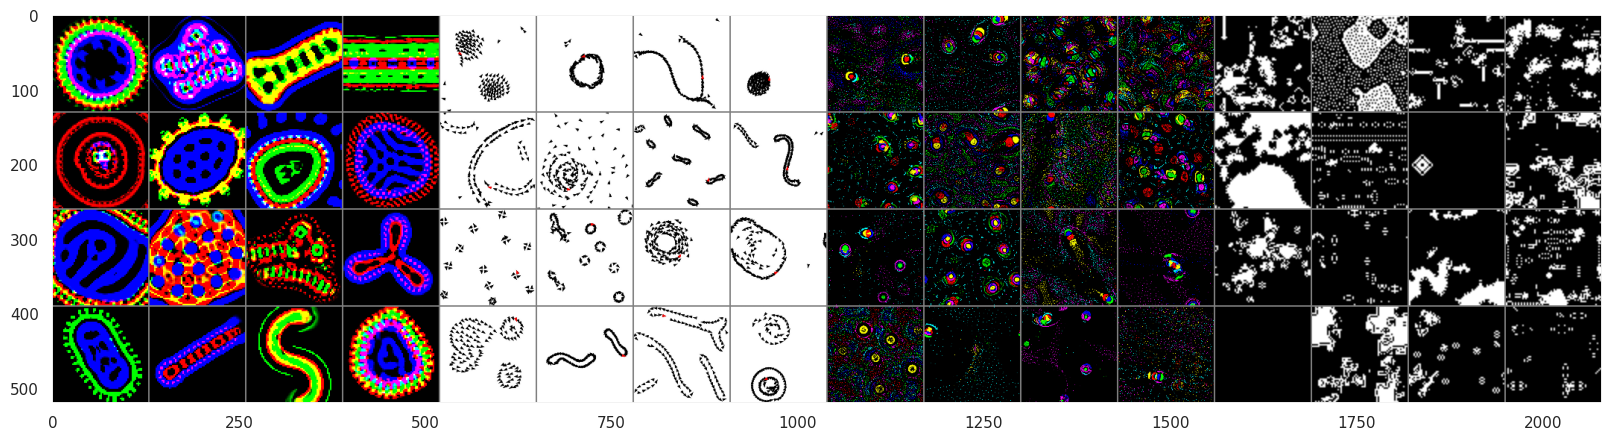

In [22]:
rng = jax.random.PRNGKey(2)
vid = np.concatenate(cover_video)
# vid = vid[jax.random.permutation(rng, len(vid))]
vid = rearrange(vid, "(A B C) T H W D -> (B A C) T H W D", A=4, B=4, C=4)
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(vid.shape)
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4)
print(vid.shape)
plt.figure(figsize=(20, 10))
plt.imshow(vid[-1])
plt.grid(False)

In [23]:
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/cover_video.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2080, 520) to (2080, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


(64, 1000, 130, 130, 3)
(1000, 520, 2080, 3)


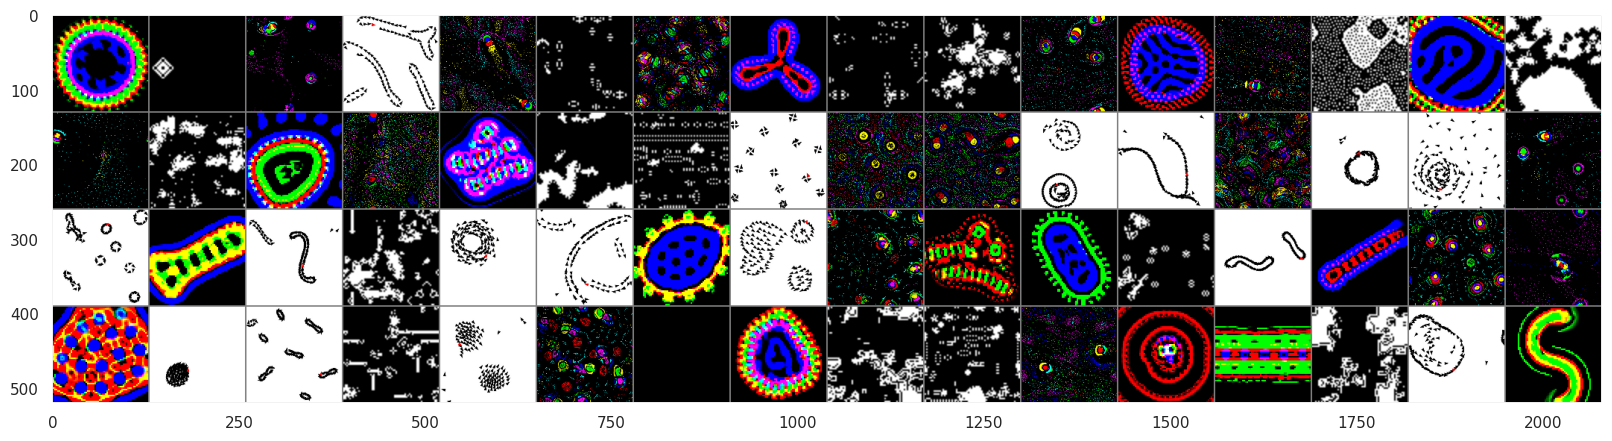

In [24]:
rng = jax.random.PRNGKey(2)
vid = np.concatenate(cover_video)
vid = vid[jax.random.permutation(rng, len(vid))]
# vid = rearrange(vid, "(A B C) T H W D -> (B A C) T H W D", A=4, B=4, C=4)
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(vid.shape)
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4)
print(vid.shape)
plt.figure(figsize=(20, 10))
plt.imshow(vid[-1])
plt.grid(False)

In [25]:
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/cover_video_shuffled.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2080, 520) to (2080, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [81]:
sim = GameOfLife(grid_size=64*3)
# rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=64, n_rollout_imgs='video'))
params = jnp.array([6152, 133519, 7291, 33823, 55871, 7787, 15923, 36703, 47999])
# params = jnp.array([15923, 133519, 7291, 33823, 6152, 55871, 7787, 36703, 47999])

rng = jax.random.PRNGKey(0)
state = sim.init_state(rng, params[0])

@jax.jit
def step_state(rng, state, params):
    state = sim.step_state(rng, state, params)
    state = sim.step_state(rng, state, params)
    return state


rule_map = repeat(jnp.arange(9).reshape(3, 3), "X Y -> (X x) (Y y)", x=64, y=64)
row_indices, col_indices = np.meshgrid(np.arange(192), np.arange(192), indexing='ij')

states = []
for t in tqdm(range(2000)):
    state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)
    state = state[rule_map, row_indices, col_indices]
    states.append(state)

states = np.array(states)



  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:
vid = np.array((repeat(states, "... -> ... 3")*255).astype(np.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/gol_mush.mp4", vid, fps=20, codec='libx264')

/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [95]:
sim = GameOfLife(grid_size=64*3)
# rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=64, n_rollout_imgs='video'))
params = jnp.array([6152, 133519, 7291, 33823, 55871, 7787, 15923, 36703, 47999])
# params = jnp.array([15923, 133519, 7291, 33823, 6152, 55871, 7787, 36703, 47999])

rng = jax.random.PRNGKey(0)
state = sim.init_state(rng, params[0])

@jax.jit
def step_state(rng, state, params):
    state = sim.step_state(rng, state, params)
    state = sim.step_state(rng, state, params)
    return state

rule_map = repeat(jnp.arange(9).reshape(3, 3), "X Y -> (X x) (Y y)", x=64, y=64)
row_indices, col_indices = np.meshgrid(np.arange(192), np.arange(192), indexing='ij')

states = []
for t in tqdm(range(200)):
    state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)
    state = state[rule_map, row_indices, col_indices]
    states.append(state)

states = np.array(states)



  0%|          | 0/200 [00:00<?, ?it/s]

In [94]:
state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)